In [28]:
import wandb
import pandas as pd
from utils.utils import plot_confidence_error, expected_calibration_error, calculate_macro_ece, calculate_auroc, calculate_auroc

In [2]:
project_name = "uncertainty-reimplimentation-results"
job_type = "steps-eval"

args = {
    
}

In [42]:
run = wandb.init(
    project=project_name,
    job_type=job_type,
)

In [43]:
table_artifact = run.use_artifact(f"run-{run-id}-table:v0")

table: pd.DataFrame = table_artifact.get("table").get_dataframe()
run.config.update(table_artifact.logged_by().config)

wandb:   1 of 1 files downloaded.  


In [44]:
failed_artifact = run.use_artifact("run-lzgpgvbh-failed:v0")
failed: pd.DataFrame = failed_artifact.get("failed").get_dataframe()

wandb:   1 of 1 files downloaded.  


In [45]:
failed

,id,question,answer,type,level,response
0,5a9050925542995651fb512f,Sky High starred the actress who is married to...,John Travolta,bridge,medium,Kurt Russell Confidence: 0.9
1,5a906beb55429916514e74b9,"Al-Battani and Ibn al-Shatir, have which mutua...",astronomer,comparison,easy,Astronomers \nConfidence: 0.9
2,5ae80c82554299540e5a5707,Chairmen of the Bored is an album that refere...,Saturday Night Live,bridge,medium,M*A*S*H Confidence: 0.8
3,5ae0cb11554299603e41845d,What instrument did Shannon Leto play in his b...,"drums, percussion",bridge,easy,Drums Confidence: 0.9
4,5a7772ac55429967ab105181,"Who was drafted into the 2009 NFL Draft, durin...",Darrius Ramar Heyward-Bey,bridge,hard,Matthew Stafford Confidence: 0.9
...,...,...,...,...,...,...
132,5abb09a45542996cc5e49f69,LinkBike has a station at the largest mall in ...,Penang,bridge,medium,Kuala Lumpur Confidence: 0.8
133,5ade49ed5542997c77adedd3,The raid of the Po Valley in 203 BC was the cu...,Carthage,bridge,easy,Carthage Confidence: 1.0
134,5abc457f55429959677d6a6e,Shin Eun-kyung is best known for her leading r...,her dying sister's wishes,bridge,medium,Her family duties \nConfidence: 0.8
135,5a81e76c554299676cceb14e,"In the 2012–13 season, Sion competes in the S...",A.C. Milan Primavera,bridge,easy,Valencia CF Confidence: 0.7


In [46]:
import re
from utils.utils import compute_exact_match, compute_f1

def extract_texts_and_confidences(response: str) -> tuple[list[str], list[float]]:
    """
    Extracts the final answer and confidence/probability from the LLM response.
    Expected format at the end:
    "Final Answer: <answer> Probability: <confidence>"
    """
    response = response.strip().replace("\n", " ")

    # Regex to catch variations in punctuation/spacing
    pattern = r"(.*?)\s*(?:Probability|Confidence)[:\-\s]*([01](?:\.\d+)?)"

    matches = re.findall(pattern, response, flags=re.MULTILINE)
    texts = [text.strip() for text, _ in matches]
    confidences = [float(confidence) for _, confidence in matches]

    return texts, confidences

def process(sample):
    texts, confidences = extract_texts_and_confidences(sample["response"])
    if not texts:
        return {}
    prediction = texts[-1]
    confidence = confidences[-1]

    return {
        "prediction" : prediction,
        "confidence" : confidence,
        "f1":  compute_f1(prediction, sample["answer"]),
        "em" : compute_exact_match(prediction, sample["answer"])
    }

repaired = pd.concat([failed, pd.DataFrame(list(failed.apply(process, axis=1)))], axis=1)
repaired = repaired.dropna()
repaired

,id,question,answer,type,level,response,prediction,confidence,f1,em
0,5a9050925542995651fb512f,Sky High starred the actress who is married to...,John Travolta,bridge,medium,Kurt Russell Confidence: 0.9,Kurt Russell,0.9,0.000000,0.0
1,5a906beb55429916514e74b9,"Al-Battani and Ibn al-Shatir, have which mutua...",astronomer,comparison,easy,Astronomers \nConfidence: 0.9,Astronomers,0.9,0.000000,0.0
2,5ae80c82554299540e5a5707,Chairmen of the Bored is an album that refere...,Saturday Night Live,bridge,medium,M*A*S*H Confidence: 0.8,M*A*S*H,0.8,0.000000,0.0
3,5ae0cb11554299603e41845d,What instrument did Shannon Leto play in his b...,"drums, percussion",bridge,easy,Drums Confidence: 0.9,Drums,0.9,0.666667,0.0
4,5a7772ac55429967ab105181,"Who was drafted into the 2009 NFL Draft, durin...",Darrius Ramar Heyward-Bey,bridge,hard,Matthew Stafford Confidence: 0.9,Matthew Stafford,0.9,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
132,5abb09a45542996cc5e49f69,LinkBike has a station at the largest mall in ...,Penang,bridge,medium,Kuala Lumpur Confidence: 0.8,Kuala Lumpur,0.8,0.000000,0.0
133,5ade49ed5542997c77adedd3,The raid of the Po Valley in 203 BC was the cu...,Carthage,bridge,easy,Carthage Confidence: 1.0,Carthage,1.0,1.000000,1.0
134,5abc457f55429959677d6a6e,Shin Eun-kyung is best known for her leading r...,her dying sister's wishes,bridge,medium,Her family duties \nConfidence: 0.8,Her family duties,0.8,0.285714,0.0
135,5a81e76c554299676cceb14e,"In the 2012–13 season, Sion competes in the S...",A.C. Milan Primavera,bridge,easy,Valencia CF Confidence: 0.7,Valencia CF,0.7,0.000000,0.0


In [47]:
table = pd.concat([table, repaired])

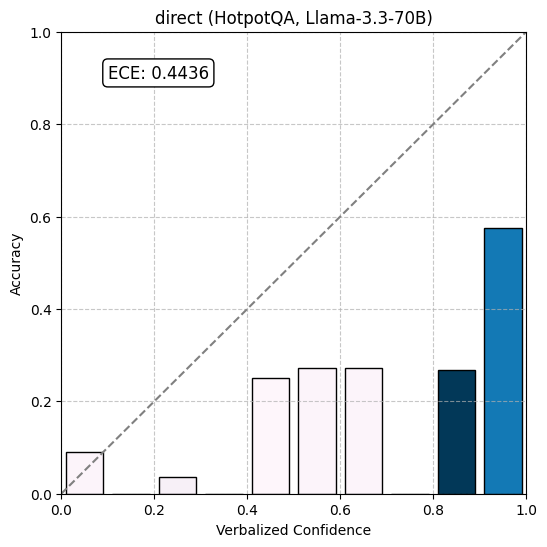

In [48]:
fig, _ = plot_confidence_error(
    table["em"],
    table["confidence"],
    title=f"{run.config.prompt} ({run.config.dataset}, {run.config.model})",
    ylabel="Accuracy",
    xlabel="Verbalized Confidence",
)

table = table.dropna()  ## remove missing rows

f1_score = table["f1"].mean()
accuracy = table["em"].mean()
ece_score = expected_calibration_error(table["em"], table["confidence"])
auroc_score = calculate_auroc(table["em"], table["confidence"])
macro_ece_score = calculate_macro_ece(table)

wandb.log(
    {
        "f1": f1_score,
        "acc": accuracy,
        "ece": ece_score,
        "auroc": auroc_score,
        "macro_ece": macro_ece_score,
    }
)

wandb.log({"calibration_plot": wandb.Image(fig)})

In [49]:
run.finish()

acc,▁
auroc,▁
ece,▁
f1,▁
macro_ece,▁
acc,0.37938
auroc,0.68437
ece,0.44361
f1,0.47248
macro_ece,0.45667
